# Executive Summary

This notebook will attempt to answer the following research question:

    What's money got to do with it?

## PLANNING

- [X] Planning
    - [X] import libraries/packages
    - [X] configure notebook environment
    - [X] define helper functions
- [X] Acquire data
    - [X] get PEIMS financial data
    - [X] get STAAR performance data
- [X] Prepare the data
    - [X] prepare PEIMS data
        - [X] get rid of unwanted columns
        - [x] get rid of NaNs
    - [X] prepare STAAR data
        - [X] get rid of duplicates
        - [X] get rid of unwanted columns
        - [X] get rid of NaNs
        - [X] create new columns
        - [X] merge two datasets together
- [ ] Explore the data
    - [ ] examine for multicollinearity and determine truly independent variables
    - [ ] get to know the master dataset
    - [ ] feature engineering
- [ ] Modeling
    - [ ] create, fit, use XGBoost
    - [ ] gridsearch
    - [ ] retrain model using best hyperparameters
    - [ ] extract feature importances

In [1]:
# for manipulating dataframes
import pandas as pd
import numpy as np

# For hypothesis testing
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

ALPHA = 0.05
mannwhitneyu_same = []
mannwhitneyu_diff = []

In [2]:
def get_values(df, columns):
    """
    Take a dataframe and a list of columns and
    returns the value counts for the columns.
    """
    for column in columns:
        print(column)
        print('=====================================')
        print(df[column].value_counts(dropna=False))
        print('\n')

def show_values(df, param):
    if param == 'all':
        get_values(df, df.columns)
    else:
        get_values(df, param)

In [3]:
def viz_correlation(df, graph_title, *cols):
     
    dfx = df[list(cols)]
    
    # Use the default Pearson for continuous variables
    corr_matrix = dfx.corr(method ='pearson')

    # Setup
    fig, ax = plt.subplots(figsize=(16,8))

    # vmin and vmax control the range of the colormap
    sns.heatmap(corr_matrix, cmap='RdBu', annot=True, fmt='.2f',
               vmin=-1, vmax=1)

    plt.title(graph_title)

    # Add tight_layout to ensure the labels don't get cut off
    plt.tight_layout()
    plt.show()

In [4]:
def viz_scatter(df, graph_title, col1, col2):
    plt.figure(figsize=(16, 8))
    plt.scatter(df[col1], df[col2], alpha=0.5)
    plt.xlabel(col1) #x label
    plt.ylabel(col2) #y label
    plt.title(graph_title)
    plt.show()

In [5]:
def viz_pairplot(df, graph_title, *cols):
     
    dfx = df[list(cols)]
    plt.figure(figsize=(16, 8))
    sns.pairplot(dfx)
    plt.title(graph_title)
    plt.show()

In [6]:
def loop_levene(df1, df2):
    for column in df1.columns:
        result = stats.levene(df1[column], df2[column])[1]
        if result > ALPHA:
            interpretation = 'insignificant - HOMOGENOUS'
        else:
            interpretation = 'significant - HETEROGENOUS'
        print(result, '-', column, ' - ', interpretation)

In [7]:
def loop_shapiro(df):
    for column in df.columns:
        statistic, result = shapiro(df[column])
        if result > ALPHA:
            interpretation = 'insignificant - NORMAL'
        else:
            interpretation = 'significant - ABNORMAL'
        print(result, '-', column, ' - ', interpretation)

In [8]:
def loop_ttest(df1, df2):
    for column in df1.columns:
        result = stats.ttest_ind(df1[column], df2[column])[1]
        if result > ALPHA:
            interpretation = 'insignificant - SAME'
        else:
            interpretation = 'significant - DIFFERENT'
        print(result, '-', column, ' - ', interpretation)

In [9]:
def loop_mannwhitney(df1, df2):

    for column in df1.columns:
        stat, p = mannwhitneyu(df1[column], df2[column])

        if p > ALPHA:
            interpretation = 'SAME (fail to reject H0)'
            print('Statistics=%.3f, p=%.3f' % (stat, p) + ' - ' + column + ' - ' + interpretation)
            mannwhitneyu_same.append(column)
        else:
            interpretation = 'DIFFERENT (reject H0)'
            print('Statistics=%.3f, p=%.3f' % (stat, p) + ' - ' + column + ' - ' + interpretation)
            mannwhitneyu_diff.append(column)

In [10]:
def viz_boxplot(df, col1, col2, graph_title):
    plt.figure(figsize=(16, 8))
    sns.boxplot(x = col1, y = col2, data = df)
    plt.title(graph_title)
    plt.show()

In [11]:
def viz_violin(df, col1, col2, graph_title):
    plt.figure(figsize=(16, 8))
    sns.violinplot(x = col1, y = col2, data = df)
    plt.title(graph_title)
    plt.show()

## ACQUIRE DATA

In [12]:
# Get the PEIMS and STAAR datasets
staar = pd.read_csv('../data/inter/clean_staar_2019.csv')
peims = pd.read_csv('../data/inter/clean_peims_2019.csv')

In [13]:
staar.head()
peims.head()

,District,Proficiency,Rate
0,1902,approaches,84.55
1,1902,masters,28.86
2,1902,meets,61.48
3,1903,approaches,83.93
4,1903,masters,26.52


,District,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,1902,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,1903,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465
2,1904,6659596,927209,937810,278109,4611747,51126,157830,0,466345,199338,0,102385,38800,411195,754465,539512,1014501,45482,409998,0,3945494,10154,552217,726827,377013,0,59567,114404,0,0,0,0,571388,2445660,481
3,1906,3134475,373513,408024,105878,2087166,19990,0,7905,379101,75235,0,40628,148301,257465,210240,201520,465549,10415,118375,0,1499301,14498,164641,447072,402415,2706,48748,29920,0,0,22400,0,0,1412589,53786
4,1907,25587063,5603896,4134969,1048416,18807861,167823,535649,1033275,2201907,1443630,170074,208736,1442619,2071781,1422648,1287489,3937087,242658,1006175,394932,15527277,39671,1625090,2422707,3147717,231026,302531,923035,0,0,52678,0,1214433,10940857,0


## PREPARATION

In [14]:
staar = staar.astype({"District": str})
peims = peims.astype({"District": str})

In [15]:
# Padd District numbers with 0's
staar['District'] = staar['District'].str.zfill(6)
peims['District'] = peims['District'].str.zfill(6)

In [16]:
# Separate by proficiency column
staar_approaches =  staar.loc[staar['Proficiency'] == 'approaches']
staar_meets =  staar.loc[staar['Proficiency'] == 'meets']
staar_masters =  staar.loc[staar['Proficiency'] == 'masters']

In [17]:
df_approaches = pd.merge(staar_approaches, peims, on=['District'])
df_meets = pd.merge(staar_meets, peims, on=['District'])
df_masters = pd.merge(staar_masters, peims, on=['District'])

In [18]:
df_approaches.head()
df_meets.head()
df_masters.head()

,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,approaches,84.55,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001902,approaches,84.55,535193214,51992341,54801828,9454304,371361946,1585886,9927708,10644882,41901599,27624583,1534271,5910337,32321948,45130399,9898476,15115454,58531070,7816390,10687937,1448801,257772938,7010472,21044878,82627668,69915588,11437734,5319962,19592708,443275,0,5058965,1925756,4102825,172616914,801985
2,001902,approaches,84.55,23658322,2788430,3551671,838431,17335920,333359,452741,422843,1766755,1069885,69696,347775,1406268,2131027,1298174,1047429,2670080,219764,236002,29136,12845578,166556,1359357,3786427,2660496,228663,581251,304299,0,46039,165838,0,968466,7935761,1375788
3,001903,approaches,83.93,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465
4,001903,approaches,83.93,424067526,25806707,49574241,7036995,311117619,5383406,10842764,6127983,28519574,21683603,790834,7124220,18036658,28485172,9783351,8567583,36029086,7063105,3407315,3523196,249219165,927436,12721301,57980032,57183458,13027250,3233671,2451253,0,44308,0,0,3149577,106592326,0


,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,meets,61.48,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001902,meets,61.48,535193214,51992341,54801828,9454304,371361946,1585886,9927708,10644882,41901599,27624583,1534271,5910337,32321948,45130399,9898476,15115454,58531070,7816390,10687937,1448801,257772938,7010472,21044878,82627668,69915588,11437734,5319962,19592708,443275,0,5058965,1925756,4102825,172616914,801985
2,001902,meets,61.48,23658322,2788430,3551671,838431,17335920,333359,452741,422843,1766755,1069885,69696,347775,1406268,2131027,1298174,1047429,2670080,219764,236002,29136,12845578,166556,1359357,3786427,2660496,228663,581251,304299,0,46039,165838,0,968466,7935761,1375788
3,001903,meets,56.40,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465
4,001903,meets,56.40,424067526,25806707,49574241,7036995,311117619,5383406,10842764,6127983,28519574,21683603,790834,7124220,18036658,28485172,9783351,8567583,36029086,7063105,3407315,3523196,249219165,927436,12721301,57980032,57183458,13027250,3233671,2451253,0,44308,0,0,3149577,106592326,0


,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,masters,28.86,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001902,masters,28.86,535193214,51992341,54801828,9454304,371361946,1585886,9927708,10644882,41901599,27624583,1534271,5910337,32321948,45130399,9898476,15115454,58531070,7816390,10687937,1448801,257772938,7010472,21044878,82627668,69915588,11437734,5319962,19592708,443275,0,5058965,1925756,4102825,172616914,801985
2,001902,masters,28.86,23658322,2788430,3551671,838431,17335920,333359,452741,422843,1766755,1069885,69696,347775,1406268,2131027,1298174,1047429,2670080,219764,236002,29136,12845578,166556,1359357,3786427,2660496,228663,581251,304299,0,46039,165838,0,968466,7935761,1375788
3,001903,masters,26.52,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465
4,001903,masters,26.52,424067526,25806707,49574241,7036995,311117619,5383406,10842764,6127983,28519574,21683603,790834,7124220,18036658,28485172,9783351,8567583,36029086,7063105,3407315,3523196,249219165,927436,12721301,57980032,57183458,13027250,3233671,2451253,0,44308,0,0,3149577,106592326,0


In [19]:
df_approaches.to_csv('../data/inter/clean_approaches_2019.csv', index=False)
df_meets.to_csv('../data/inter/clean_meets_2019.csv', index=False)
df_masters.to_csv('../data/inter/clean_masters_2019.csv', index=False)

## EXPLORATION

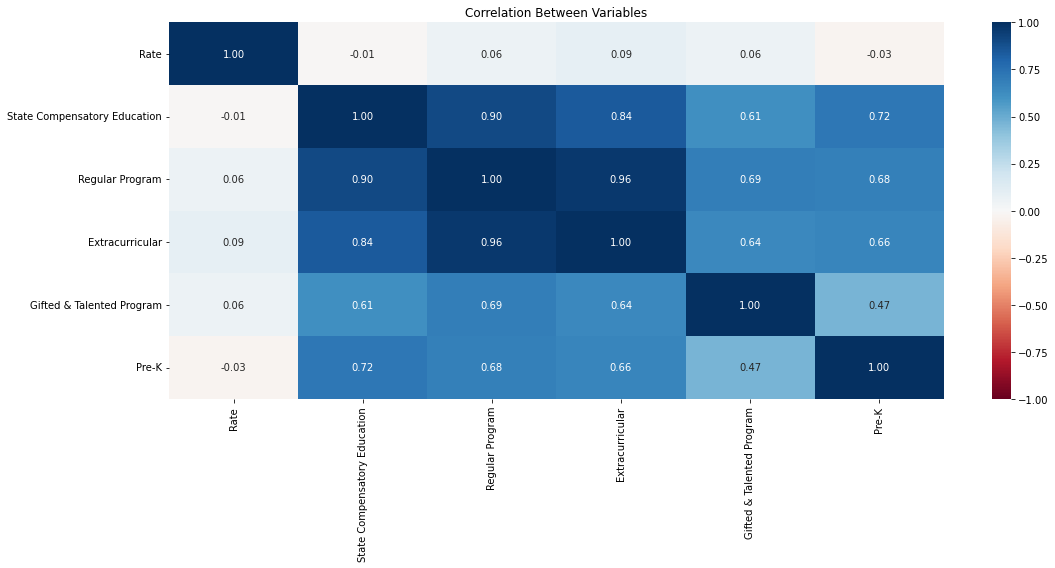

In [20]:
viz_correlation(df_approaches, 'Correlation Between Variables',
                'Rate',
                'State Compensatory Education',
                'Regular Program',
                'Extracurricular',
                'Gifted & Talented Program',
                'Pre-K'
               )

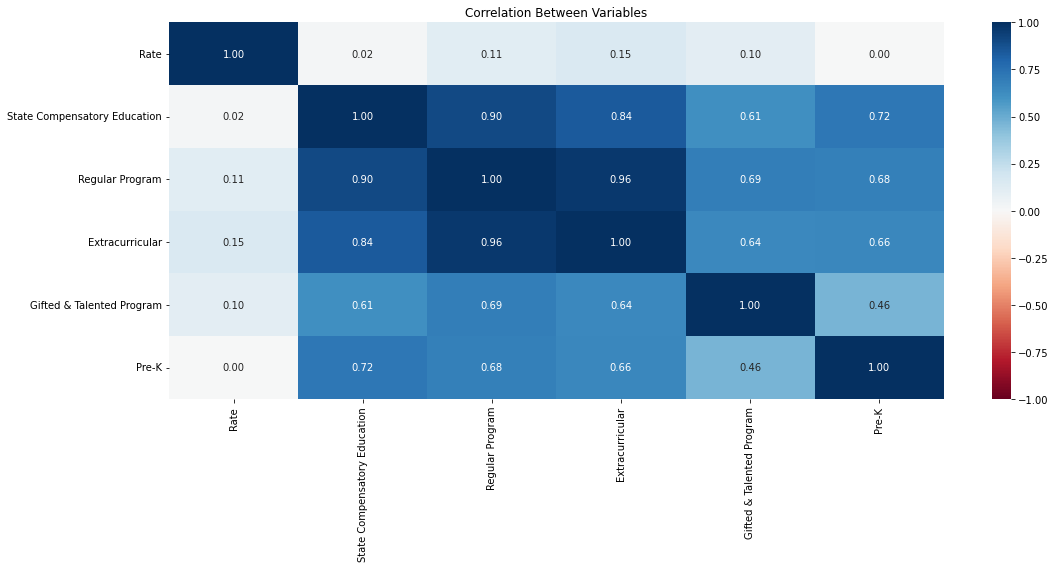

In [21]:
viz_correlation(df_meets, 'Correlation Between Variables',
                'Rate',
                'State Compensatory Education',
                'Regular Program',
                'Extracurricular',
                'Gifted & Talented Program',
                'Pre-K'
               )

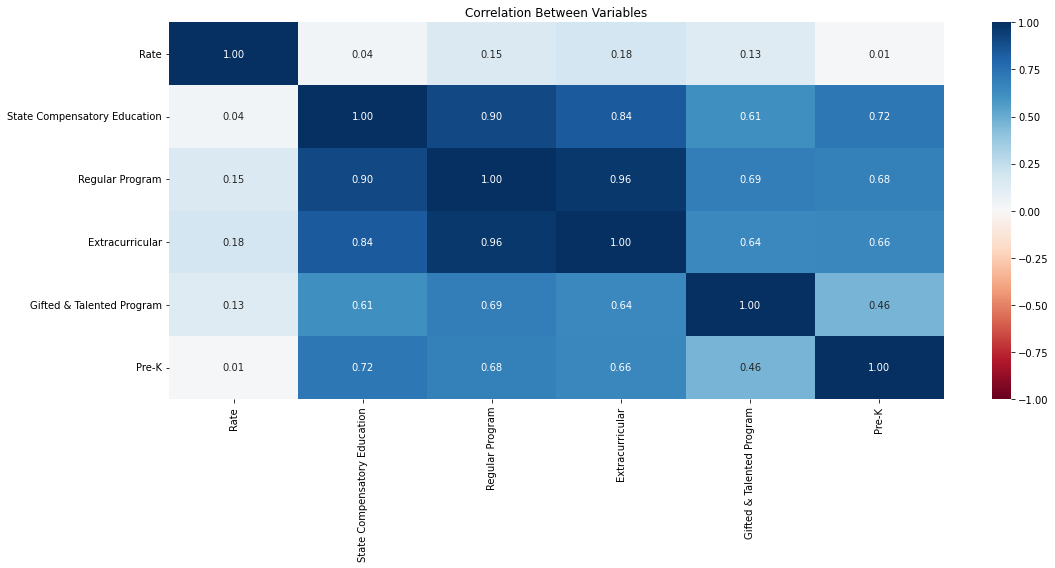

In [22]:
viz_correlation(df_masters, 'Correlation Between Variables',
                'Rate',
                'State Compensatory Education',
                'Regular Program',
                'Extracurricular',
                'Gifted & Talented Program',
                'Pre-K'
               )

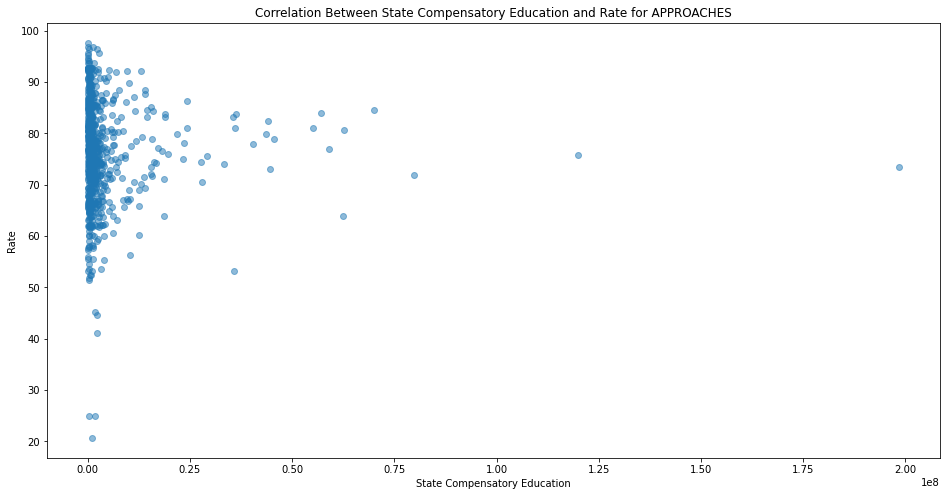

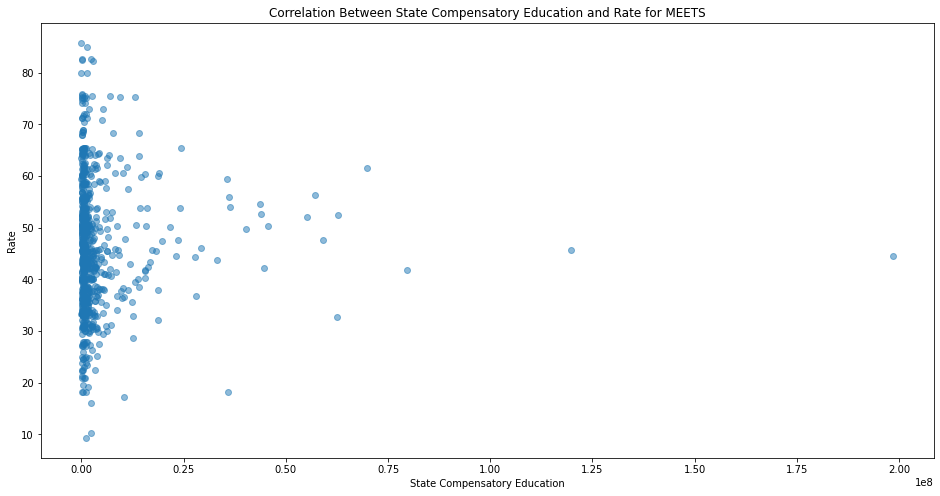

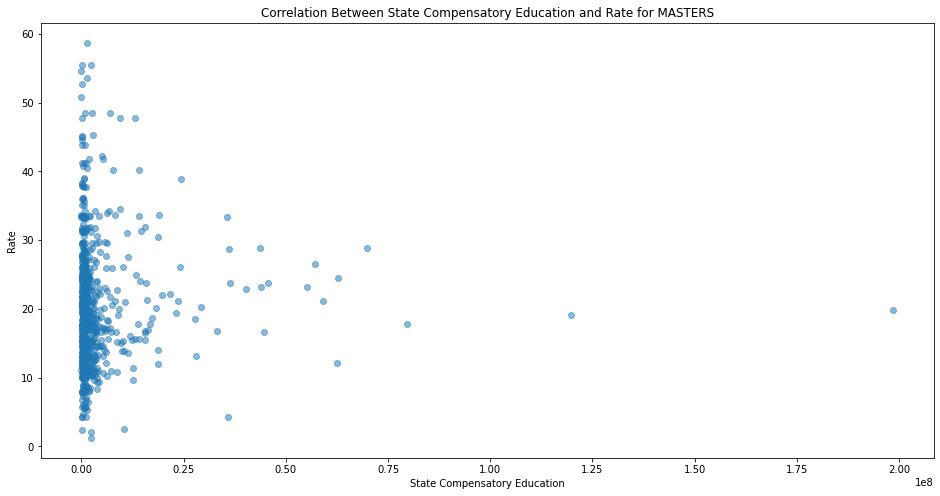

In [23]:
viz_scatter(df_approaches, 'Correlation Between State Compensatory Education and Rate for APPROACHES', 'State Compensatory Education', 'Rate')
viz_scatter(df_meets, 'Correlation Between State Compensatory Education and Rate for MEETS', 'State Compensatory Education', 'Rate')
viz_scatter(df_masters, 'Correlation Between State Compensatory Education and Rate for MASTERS', 'State Compensatory Education', 'Rate')

<Figure size 1152x576 with 0 Axes>

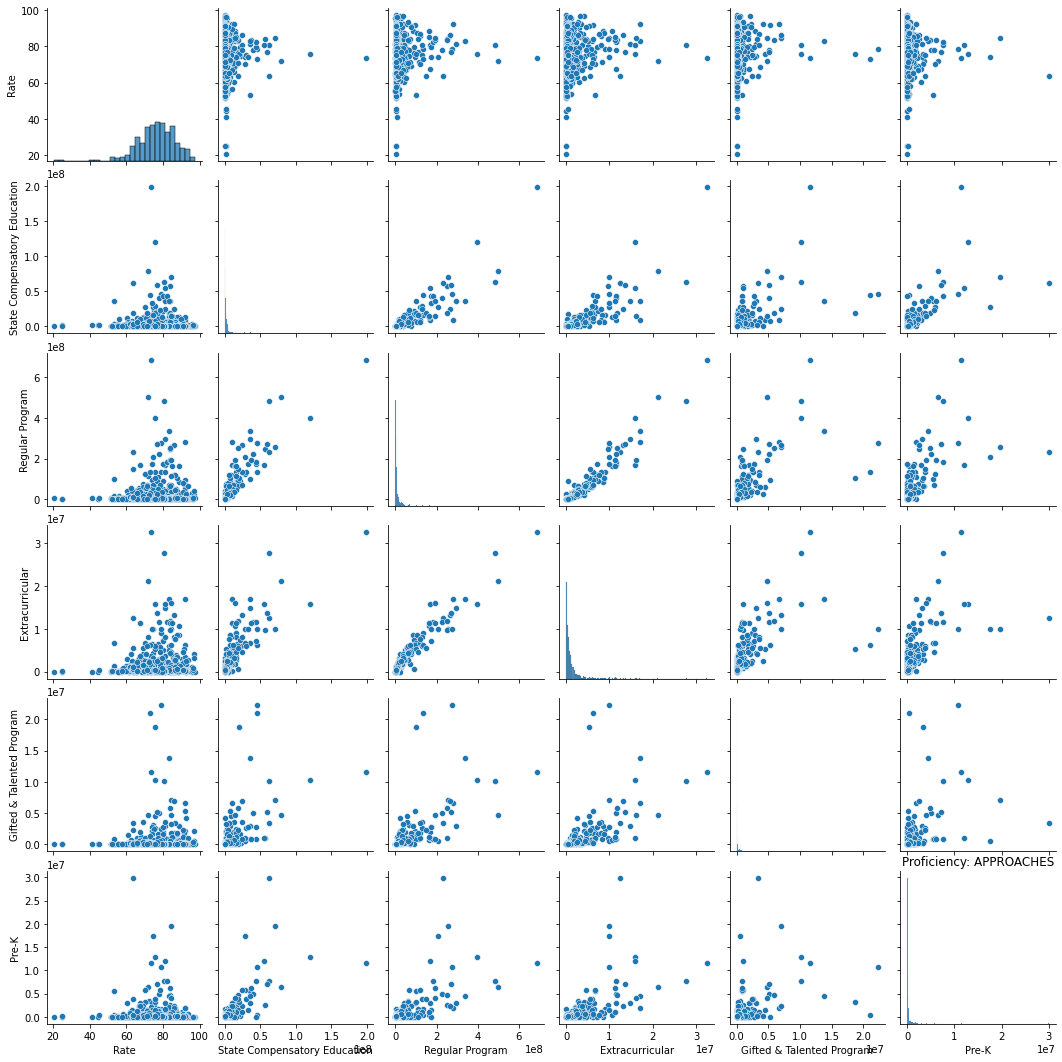

<Figure size 1152x576 with 0 Axes>

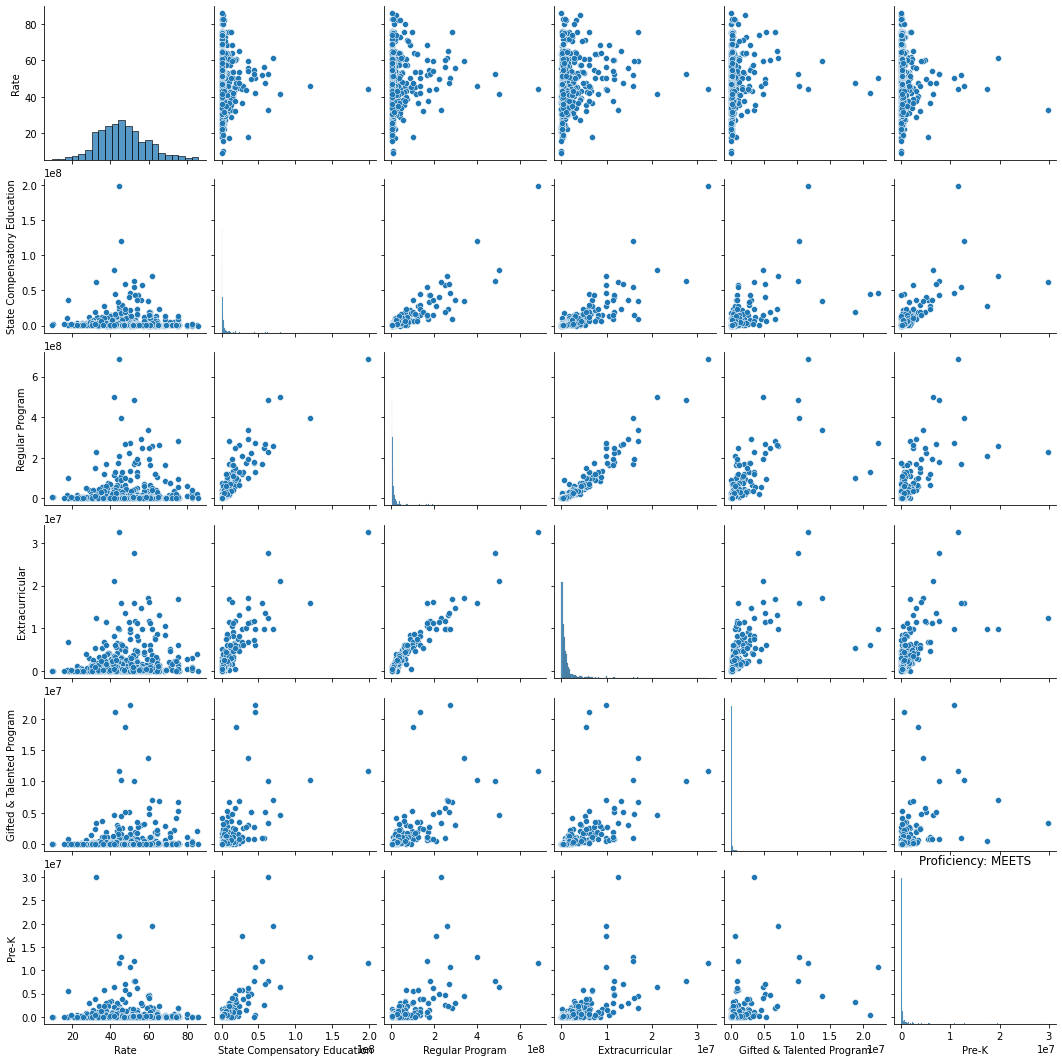

<Figure size 1152x576 with 0 Axes>

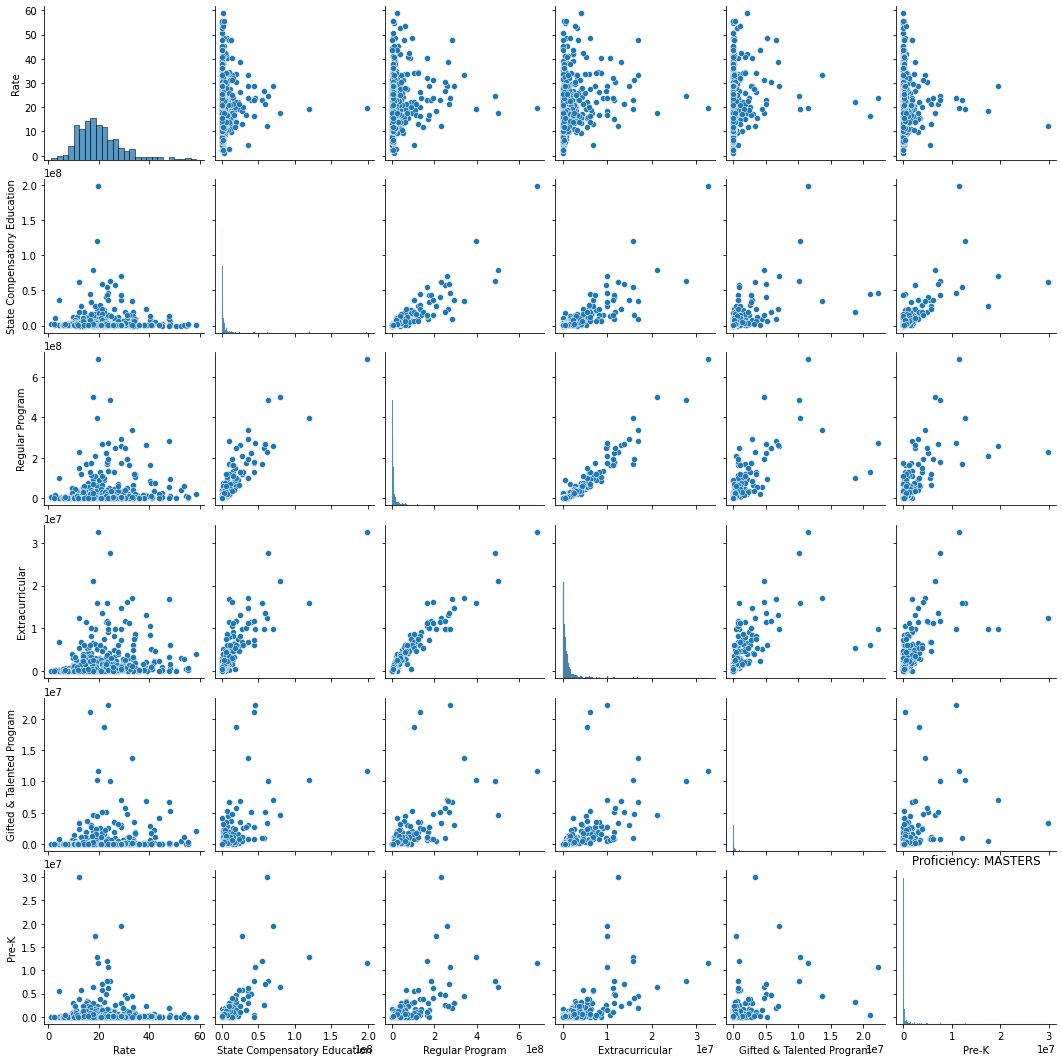

In [24]:
viz_pairplot(df_approaches, 'Proficiency: APPROACHES',
                'Rate',
                'State Compensatory Education',
                'Regular Program',
                'Extracurricular',
                'Gifted & Talented Program',
                'Pre-K'
               )

viz_pairplot(df_meets, 'Proficiency: MEETS',
                'Rate',
                'State Compensatory Education',
                'Regular Program',
                'Extracurricular',
                'Gifted & Talented Program',
                'Pre-K'
               )

viz_pairplot(df_masters, 'Proficiency: MASTERS',
                'Rate',
                'State Compensatory Education',
                'Regular Program',
                'Extracurricular',
                'Gifted & Talented Program',
                'Pre-K'
               )

In [25]:
df_approaches.head(2)
df_meets.head(2)
df_masters.head(2)

,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,approaches,84.55,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001902,approaches,84.55,535193214,51992341,54801828,9454304,371361946,1585886,9927708,10644882,41901599,27624583,1534271,5910337,32321948,45130399,9898476,15115454,58531070,7816390,10687937,1448801,257772938,7010472,21044878,82627668,69915588,11437734,5319962,19592708,443275,0,5058965,1925756,4102825,172616914,801985


,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,meets,61.48,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001902,meets,61.48,535193214,51992341,54801828,9454304,371361946,1585886,9927708,10644882,41901599,27624583,1534271,5910337,32321948,45130399,9898476,15115454,58531070,7816390,10687937,1448801,257772938,7010472,21044878,82627668,69915588,11437734,5319962,19592708,443275,0,5058965,1925756,4102825,172616914,801985


,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,masters,28.86,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001902,masters,28.86,535193214,51992341,54801828,9454304,371361946,1585886,9927708,10644882,41901599,27624583,1534271,5910337,32321948,45130399,9898476,15115454,58531070,7816390,10687937,1448801,257772938,7010472,21044878,82627668,69915588,11437734,5319962,19592708,443275,0,5058965,1925756,4102825,172616914,801985


In [26]:
dfx_approaches = df_approaches.drop(columns=['District', 'Proficiency'])
dfx_meets = df_meets.drop(columns=['District', 'Proficiency'])
dfx_masters = df_masters.drop(columns=['District', 'Proficiency'])

In [27]:
approaches = dfx_approaches.copy()
meets = dfx_meets.copy()
masters = dfx_masters.copy()

In [28]:
loop_levene(approaches, masters)

0.0016557834487123196 - Rate  -  significant - HETEROGENOUS
0.987795427584901 - Payroll  -  insignificant - HOMOGENOUS
0.9845085306529694 - Professional & Contracted  -  insignificant - HOMOGENOUS
0.9881254410949315 - Supplies & Materials  -  insignificant - HOMOGENOUS
0.9863245815152883 - Other Operating  -  insignificant - HOMOGENOUS
0.9873924614578032 - Instruction & Transfer  -  insignificant - HOMOGENOUS
0.9888513122890131 - Instructional Resource Media  -  insignificant - HOMOGENOUS
0.9885530112675718 - Curriculum/Staff Development  -  insignificant - HOMOGENOUS
0.9874661969021582 - Instructional Leadership  -  insignificant - HOMOGENOUS
0.9880734809114199 - Campus Administration  -  insignificant - HOMOGENOUS
0.9890204474774306 - Guidance & Counseling  -  insignificant - HOMOGENOUS
0.9901909038775605 - Social Work  -  insignificant - HOMOGENOUS
0.9893168174568246 - Health Services  -  insignificant - HOMOGENOUS
0.9890920572554847 - Transportation  -  insignificant - HOMOGENOUS
0

In [29]:
loop_shapiro(approaches)
loop_shapiro(meets)
loop_shapiro(masters)

5.79320825252333e-13 - Rate  -  significant - ABNORMAL
4.203895392974451e-45 - Payroll  -  significant - ABNORMAL
2.0178697886277366e-43 - Professional & Contracted  -  significant - ABNORMAL
9.80908925027372e-45 - Supplies & Materials  -  significant - ABNORMAL
2.122967173452098e-42 - Other Operating  -  significant - ABNORMAL
7.006492321624085e-45 - Instruction & Transfer  -  significant - ABNORMAL
5.605193857299268e-45 - Instructional Resource Media  -  significant - ABNORMAL
0.0 - Curriculum/Staff Development  -  significant - ABNORMAL
1.401298464324817e-45 - Instructional Leadership  -  significant - ABNORMAL
7.006492321624085e-45 - Campus Administration  -  significant - ABNORMAL
2.802596928649634e-45 - Guidance & Counseling  -  significant - ABNORMAL
0.0 - Social Work  -  significant - ABNORMAL
1.401298464324817e-45 - Health Services  -  significant - ABNORMAL
2.802596928649634e-45 - Transportation  -  significant - ABNORMAL
1.401298464324817e-45 - Food Service  -  significant -

In [30]:
loop_ttest(approaches, masters)

0.0 - Rate  -  significant - DIFFERENT
0.9865302984282136 - Payroll  -  insignificant - SAME
0.987124451041614 - Professional & Contracted  -  insignificant - SAME
0.9853318082085865 - Supplies & Materials  -  insignificant - SAME
0.9826169132521154 - Other Operating  -  insignificant - SAME
0.9867297371421077 - Instruction & Transfer  -  insignificant - SAME
0.9853814164432535 - Instructional Resource Media  -  insignificant - SAME
0.9886782854142043 - Curriculum/Staff Development  -  insignificant - SAME
0.9879131684363507 - Instructional Leadership  -  insignificant - SAME
0.9873986691068435 - Campus Administration  -  insignificant - SAME
0.9883494850624481 - Guidance & Counseling  -  insignificant - SAME
0.9901909038790836 - Social Work  -  insignificant - SAME
0.9859845874261816 - Health Services  -  insignificant - SAME
0.9853449256141618 - Transportation  -  insignificant - SAME
0.9855915994590871 - Food Service  -  insignificant - SAME
0.9797934230746546 - Extracurricular  -  

In [31]:
df0 = df_approaches.copy()
df1 = df_meets.copy()
df2 = df_masters.copy()

In [32]:
clean = pd.concat([df0, df1, df2])
clean.head()

,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,approaches,84.55,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001902,approaches,84.55,535193214,51992341,54801828,9454304,371361946,1585886,9927708,10644882,41901599,27624583,1534271,5910337,32321948,45130399,9898476,15115454,58531070,7816390,10687937,1448801,257772938,7010472,21044878,82627668,69915588,11437734,5319962,19592708,443275,0,5058965,1925756,4102825,172616914,801985
2,001902,approaches,84.55,23658322,2788430,3551671,838431,17335920,333359,452741,422843,1766755,1069885,69696,347775,1406268,2131027,1298174,1047429,2670080,219764,236002,29136,12845578,166556,1359357,3786427,2660496,228663,581251,304299,0,46039,165838,0,968466,7935761,1375788
3,001903,approaches,83.93,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465
4,001903,approaches,83.93,424067526,25806707,49574241,7036995,311117619,5383406,10842764,6127983,28519574,21683603,790834,7124220,18036658,28485172,9783351,8567583,36029086,7063105,3407315,3523196,249219165,927436,12721301,57980032,57183458,13027250,3233671,2451253,0,44308,0,0,3149577,106592326,0


In [33]:
clean[clean['District'] == '001902']

,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses
0,001902,approaches,84.55,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001902,approaches,84.55,535193214,51992341,54801828,9454304,371361946,1585886,9927708,10644882,41901599,27624583,1534271,5910337,32321948,45130399,9898476,15115454,58531070,7816390,10687937,1448801,257772938,7010472,21044878,82627668,69915588,11437734,5319962,19592708,443275,0,5058965,1925756,4102825,172616914,801985
2,001902,approaches,84.55,23658322,2788430,3551671,838431,17335920,333359,452741,422843,1766755,1069885,69696,347775,1406268,2131027,1298174,1047429,2670080,219764,236002,29136,12845578,166556,1359357,3786427,2660496,228663,581251,304299,0,46039,165838,0,968466,7935761,1375788
0,001902,meets,61.48,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001902,meets,61.48,535193214,51992341,54801828,9454304,371361946,1585886,9927708,10644882,41901599,27624583,1534271,5910337,32321948,45130399,9898476,15115454,58531070,7816390,10687937,1448801,257772938,7010472,21044878,82627668,69915588,11437734,5319962,19592708,443275,0,5058965,1925756,4102825,172616914,801985
2,001902,meets,61.48,23658322,2788430,3551671,838431,17335920,333359,452741,422843,1766755,1069885,69696,347775,1406268,2131027,1298174,1047429,2670080,219764,236002,29136,12845578,166556,1359357,3786427,2660496,228663,581251,304299,0,46039,165838,0,968466,7935761,1375788
0,001902,masters,28.86,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633
1,001902,masters,28.86,535193214,51992341,54801828,9454304,371361946,1585886,9927708,10644882,41901599,27624583,1534271,5910337,32321948,45130399,9898476,15115454,58531070,7816390,10687937,1448801,257772938,7010472,21044878,82627668,69915588,11437734,5319962,19592708,443275,0,5058965,1925756,4102825,172616914,801985
2,001902,masters,28.86,23658322,2788430,3551671,838431,17335920,333359,452741,422843,1766755,1069885,69696,347775,1406268,2131027,1298174,1047429,2670080,219764,236002,29136,12845578,166556,1359357,3786427,2660496,228663,581251,304299,0,46039,165838,0,968466,7935761,1375788


In [34]:
clean = clean.loc[clean['Proficiency'] == 'approaches']

In [35]:
clean['Efficient'] = np.where(clean['Rate'] < 70, 1, 0)

In [36]:
clean[clean['District'] == '001902']

,District,Proficiency,Rate,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses,Efficient
0,001902,approaches,84.55,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633,0
1,001902,approaches,84.55,535193214,51992341,54801828,9454304,371361946,1585886,9927708,10644882,41901599,27624583,1534271,5910337,32321948,45130399,9898476,15115454,58531070,7816390,10687937,1448801,257772938,7010472,21044878,82627668,69915588,11437734,5319962,19592708,443275,0,5058965,1925756,4102825,172616914,801985,0
2,001902,approaches,84.55,23658322,2788430,3551671,838431,17335920,333359,452741,422843,1766755,1069885,69696,347775,1406268,2131027,1298174,1047429,2670080,219764,236002,29136,12845578,166556,1359357,3786427,2660496,228663,581251,304299,0,46039,165838,0,968466,7935761,1375788,0


In [37]:
clean.shape

(744, 39)

In [38]:
show_values(clean, ['Efficient'])

Efficient
0    578
1    166
Name: Efficient, dtype: int64




In [39]:
clean = clean.drop(columns=['Proficiency', 'Rate'])

In [40]:
clean = clean.drop(columns=['District'])

In [41]:
clean.shape

(744, 36)

In [42]:
clean.head()

,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Pre-K Bilingual,Pre-K Comp Ed,Pre-K Regular,Pre-K Special Education,Athletics Program,Undistributed Program,Other Uses,Efficient
0,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,0,0,0,0,304174,1858660,48633,0
1,535193214,51992341,54801828,9454304,371361946,1585886,9927708,10644882,41901599,27624583,1534271,5910337,32321948,45130399,9898476,15115454,58531070,7816390,10687937,1448801,257772938,7010472,21044878,82627668,69915588,11437734,5319962,19592708,443275,0,5058965,1925756,4102825,172616914,801985,0
2,23658322,2788430,3551671,838431,17335920,333359,452741,422843,1766755,1069885,69696,347775,1406268,2131027,1298174,1047429,2670080,219764,236002,29136,12845578,166556,1359357,3786427,2660496,228663,581251,304299,0,46039,165838,0,968466,7935761,1375788,0
3,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,0,0,0,0,339045,3262276,102465,0
4,424067526,25806707,49574241,7036995,311117619,5383406,10842764,6127983,28519574,21683603,790834,7124220,18036658,28485172,9783351,8567583,36029086,7063105,3407315,3523196,249219165,927436,12721301,57980032,57183458,13027250,3233671,2451253,0,44308,0,0,3149577,106592326,0,0


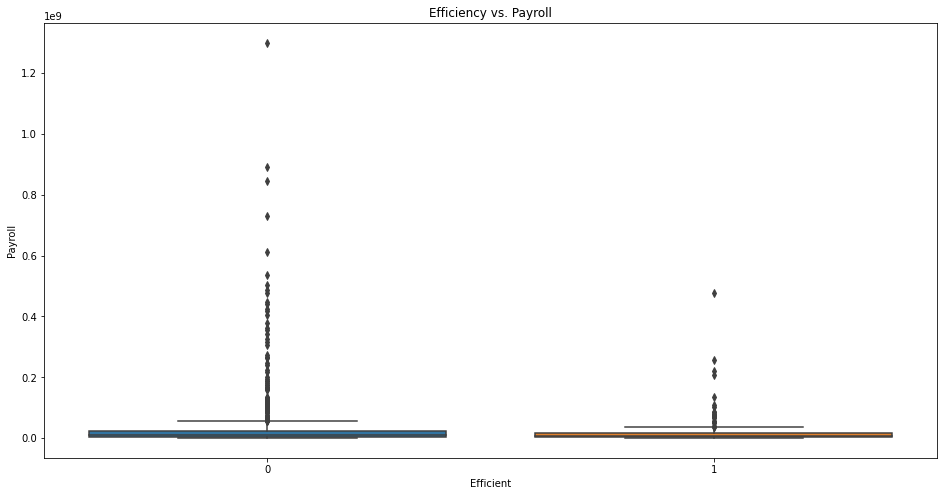

In [43]:
viz_boxplot(clean, 'Efficient', 'Payroll', 'Efficiency vs. Payroll')

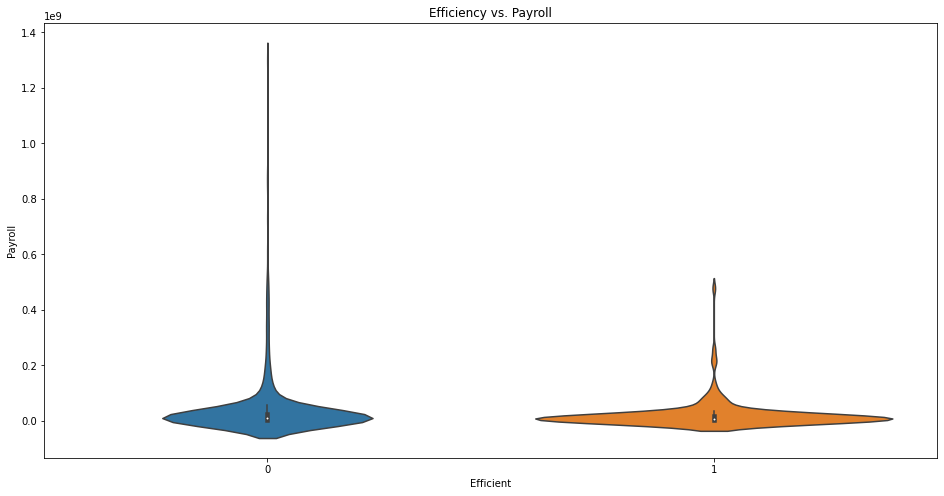

In [44]:
viz_violin(clean, 'Efficient', 'Payroll', 'Efficiency vs. Payroll')

In [45]:
# Separate by Efficient column
clean_0 =  clean.loc[clean['Efficient'] == 0]
clean_1 =  clean.loc[clean['Efficient'] == 1]

In [46]:
loop_levene(clean_0, clean_1)

0.030295716608556723 - Payroll  -  significant - HETEROGENOUS
0.10214285969918754 - Professional & Contracted  -  insignificant - HOMOGENOUS
0.06219231075206154 - Supplies & Materials  -  insignificant - HOMOGENOUS
0.025615355061236366 - Other Operating  -  significant - HETEROGENOUS
0.026452993305029163 - Instruction & Transfer  -  significant - HETEROGENOUS
0.02164508868107503 - Instructional Resource Media  -  significant - HETEROGENOUS
0.23844735915873655 - Curriculum/Staff Development  -  insignificant - HOMOGENOUS
0.09362084428747502 - Instructional Leadership  -  insignificant - HOMOGENOUS
0.0589253548874592 - Campus Administration  -  insignificant - HOMOGENOUS
0.04295425745191634 - Guidance & Counseling  -  significant - HETEROGENOUS
0.4415281623733597 - Social Work  -  insignificant - HOMOGENOUS
0.043806381359955876 - Health Services  -  significant - HETEROGENOUS
0.027116263192661666 - Transportation  -  significant - HETEROGENOUS
0.07623960022969609 - Food Service  -  insig

C:\Users\Dd\OneDrive\Documents\_github\texas-public-schools\v399\lib\site-packages\scipy\stats\_morestats.py:2604: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


In [47]:
loop_shapiro(clean_0)
loop_shapiro(clean_1)

1.6039822742047586e-40 - Payroll  -  significant - ABNORMAL
3.327671871022929e-39 - Professional & Contracted  -  significant - ABNORMAL
2.6828980138270083e-40 - Supplies & Materials  -  significant - ABNORMAL
4.0352466004557237e-38 - Other Operating  -  significant - ABNORMAL
2.2209739880469756e-40 - Instruction & Transfer  -  significant - ABNORMAL
2.009251803072139e-40 - Instructional Resource Media  -  significant - ABNORMAL
6.850948192084031e-42 - Curriculum/Staff Development  -  significant - ABNORMAL
2.552044763228357e-41 - Instructional Leadership  -  significant - ABNORMAL
1.797627708989805e-40 - Campus Administration  -  significant - ABNORMAL
7.701676489775627e-41 - Guidance & Counseling  -  significant - ABNORMAL
5.324934164434305e-43 - Social Work  -  significant - ABNORMAL
8.505741548605207e-41 - Health Services  -  significant - ABNORMAL
8.671795416627698e-41 - Transportation  -  significant - ABNORMAL
4.876378526003931e-41 - Food Service  -  significant - ABNORMAL
6.590

C:\Users\Dd\OneDrive\Documents\_github\texas-public-schools\v399\lib\site-packages\scipy\stats\_morestats.py:1758: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [48]:
loop_mannwhitney(clean_0, clean_1)

Statistics=53927.000, p=0.015 - Payroll - DIFFERENT (reject H0)
Statistics=50082.000, p=0.388 - Professional & Contracted - SAME (fail to reject H0)
Statistics=54117.000, p=0.012 - Supplies & Materials - DIFFERENT (reject H0)
Statistics=51379.000, p=0.163 - Other Operating - SAME (fail to reject H0)
Statistics=53897.000, p=0.015 - Instruction & Transfer - DIFFERENT (reject H0)
Statistics=58744.500, p=0.000 - Instructional Resource Media - DIFFERENT (reject H0)
Statistics=49466.000, p=0.541 - Curriculum/Staff Development - SAME (fail to reject H0)
Statistics=50720.000, p=0.256 - Instructional Leadership - SAME (fail to reject H0)
Statistics=51630.500, p=0.134 - Campus Administration - SAME (fail to reject H0)
Statistics=54171.500, p=0.011 - Guidance & Counseling - DIFFERENT (reject H0)
Statistics=46243.000, p=0.386 - Social Work - SAME (fail to reject H0)
Statistics=54591.000, p=0.007 - Health Services - DIFFERENT (reject H0)
Statistics=55323.500, p=0.003 - Transportation - DIFFERENT (r

In [49]:
mannwhitneyu_same

['Professional & Contracted',
 'Other Operating',
 'Curriculum/Staff Development',
 'Instructional Leadership',
 'Campus Administration',
 'Social Work',
 'Food Service',
 'General Administration',
 'Security & Monitoring',
 'Data Processing',
 'Community Services',
 'State Compensatory Education',
 'Bilingual Program',
 'Pre-K',
 'Pre-K Comp Ed',
 'Pre-K Special Education',
 'Undistributed Program',
 'Other Uses']

In [50]:
mannwhitneyu_diff

['Payroll',
 'Supplies & Materials',
 'Instruction & Transfer',
 'Instructional Resource Media',
 'Guidance & Counseling',
 'Health Services',
 'Transportation',
 'Extracurricular',
 'Plant Maintenance/Operation',
 'Regular Program',
 'Gifted & Talented Program',
 'Career & Technology Program',
 'Students with Disabilities',
 'High School Allotment',
 'Pre-K Bilingual',
 'Pre-K Regular',
 'Athletics Program',
 'Efficient']

In [51]:
clean.to_csv('../data/inter/clean_efficient_2019.csv', index=False)